# YouTube on Android

The goal of this experiment is to run Youtube videos on a Pixel device running Android and collect results.

In [1]:
from conf import LisaLogging
import logging
LisaLogging.setup(level=logging.DEBUG)

2017-09-07 02:44:47,143 INFO    : root         : Using LISA logging configuration:
2017-09-07 02:44:47,144 INFO    : root         :   /home/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import System, Screen, Workload

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    
    # Configure governor
    target.cpufreq.set_all_governors('sched')

    # Get workload
    wload = Workload(te).getInstance(te, 'YouTube')
    
    # Run Youtube workload
    wload.run(te.res_dir, 'https://youtu.be/XSGBVzeBUbk?t=45s',
              video_duration_s=5, collect='ftrace')

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },


    # Folder where all the results will be collected
    "results_dir" : "Youtube_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq',       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
             
            # Add here the events you wanna enable by hand
            "sched_energy_diff",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset' ],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2017-09-07 02:44:51,753 INFO    : TestEnv      : Using base path: /home/lisa/lisa-github
2017-09-07 02:44:51,756 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-09-07 02:44:51,757 INFO    : TestEnv      : External tools using:
2017-09-07 02:44:51,758 INFO    : TestEnv      :    ANDROID_HOME: /home/lisa/android-sdk
2017-09-07 02:44:51,760 INFO    : TestEnv      :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
2017-09-07 02:44:51,761 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-09-07 02:44:51,762 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-09-07 02:44:51,763 INFO    : TestEnv      : Connection settings:
2017-09-07 02:44:51,764 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2017-09-07 02:44:52,318 INFO    : TestEnv      : Initializing target workdir:
2017-09-07 02:44:52,320 INFO    : TestEnv      :    /data/local/tmp/devlib-target
2017-09-07 02:44:53,894 INFO    : TestEnv  

In [6]:
# ADB ROOT is requried for systrace to be able to get the generated trace from the target
!adb root

adbd is already running as root


## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **Youtube** experiment.

In [7]:
# Intialize Workloads for this test environment
results = experiment()

2017-09-07 02:45:01,990 INFO    : Workload     : Packages:
['com.android.cts.priv.ctsshim', 'com.android.providers.telephony', 'com.android.providers.calendar', 'com.android.providers.media', 'com.android.wallpapercropper', 'com.android.launcher', 'com.antutu.ABenchMark', 'com.android.documentsui', 'com.android.externalstorage', 'com.android.htmlviewer', 'com.android.quicksearchbox', 'com.android.mms.service', 'com.android.providers.downloads', 'com.primatelabs.geekbench', 'com.antutu.benchmark.full', 'com.android.defcontainer', 'com.android.providers.downloads.ui', 'com.android.pacprocessor', 'com.android.certinstaller', 'android', 'com.android.contacts', 'com.android.camera2', 'com.android.egg', 'com.android.mtp', 'com.android.backupconfirm', 'com.android.provision', 'com.android.statementservice', 'com.android.calendar', 'com.android.providers.settings', 'com.android.sharedstoragebackup', 'com.android.printspooler', 'com.android.dreams.basic', 'com.android.webview', 'com.android.inp

2017-09-07 02:45:17,541 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-09-07 02:45:17,724 INFO    : YouTube      : FTrace STOP
2017-09-07 02:45:20,210 INFO    : System       : am force-stop com.paraphron.youtube
2017-09-07 02:45:20,818 INFO    : Screen       : Set orientation: AUTO
2017-09-07 02:45:21,671 INFO    : Screen       : Set brightness: AUTO


## Benchmarks results

In [8]:
# Benchmark statistics
db_file = os.path.join(te.res_dir, "framestats.txt")
!sed '/Stats since/,/99th/!d;/99th/q' {db_file}

# For all results:
# !cat {results['db_file']}

Stats since: 2308261248604ns
Total frames rendered: 537
Janky frames: 20 (3.72%)
50th percentile: 5ms
90th percentile: 12ms
95th percentile: 15ms
99th percentile: 26ms


## Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [12]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

trappy.plotter.plot_trace(trace.ftrace)

2017-09-07 02:46:05,960 DEBUG   : Trace        : Loading [sched] events from trace in [/home/lisa/lisa-github/results/Youtube_example/trace.dat]...
2017-09-07 02:46:05,962 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_wakeup', 'sched_wakeup_new', 'sched_overutilized', 'sched_load_avg_cpu', 'sched_load_avg_task', 'cpu_capacity', 'cpu_frequency', 'sched_energy_diff', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2017-09-07 02:46:05,963 DEBUG   : Trace        : Parsing FTrace format...
2017-09-07 02:46:06,666 DEBUG   : Trace        : Events found on trace:
2017-09-07 02:46:06,667 DEBUG   : Trace        :  - sched_load_avg_task
2017-09-07 02:46:06,668 DEBUG   : Trace        :  - cpu_frequency
2017-09-07 02:46:06,670 DEBUG   : Trace        :  - cpu_capacity
2017-09-07 02:46:06,674 DEBUG   : Trace        :  - sched_load_avg_cpu
2017-09-07 02:46:06,675 DEBUG   : Trace        :  - sched_wakeup_new
2017-09-07 02:46:06,677 DEBUG   : Trace        :  - cpu_frequency_devlib
201

2017-09-07 02:46:07,167 DEBUG   : Analysis     :    latency
2017-09-07 02:46:07,168 DEBUG   : Analysis     : Filename: status_analysis
2017-09-07 02:46:07,170 DEBUG   : Analysis     : Parsing big.LITTLE system clusters
2017-09-07 02:46:07,171 DEBUG   : Trace        : Registering [<status_analysis.StatusAnalysis object at 0x7fd76d42f450>] local data frames
2017-09-07 02:46:07,173 DEBUG   : Trace        :    overutilized
2017-09-07 02:46:07,174 DEBUG   : Trace        :    trace_event
2017-09-07 02:46:07,176 DEBUG   : Analysis     :    status
2017-09-07 02:46:07,177 DEBUG   : Analysis     : Filename: tasks_analysis
2017-09-07 02:46:07,178 DEBUG   : Analysis     : Parsing big.LITTLE system clusters
2017-09-07 02:46:07,180 DEBUG   : Trace        : Registering [<tasks_analysis.TasksAnalysis object at 0x7fd76d42f350>] local data frames
2017-09-07 02:46:07,181 DEBUG   : Trace        :    rt_tasks
2017-09-07 02:46:07,183 DEBUG   : Trace        :    top_big_tasks
2017-09-07 02:46:07,184 DEBUG   

2017-09-07 02:45:37,362 INFO    : Analysis     : LITTLE cluster average frequency: 1.503 GHz
2017-09-07 02:45:37,363 INFO    : Analysis     : big    cluster average frequency: 1.395 GHz
2017-09-07 02:45:37,364 INFO    : root         : Plotting cluster frequencies for [sched]...


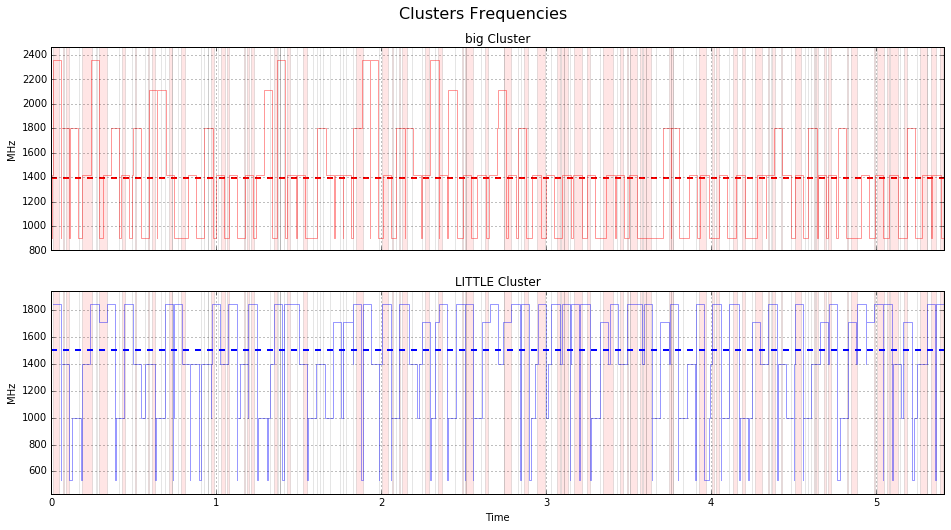

In [10]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass

In [11]:
df = trace.data_frame.trace_event('sched_energy_diff')

In [ ]:
df.head()